In [1]:
from dataLoader import dataloader
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import models.EEGNet
import models.DeepConvNet
import models.ShallowConvNet
from utils import utils
import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_data, train_label, test_data, test_label = dataloader.read_bci_data()
train_dataset = TensorDataset(torch.from_numpy(train_data).float(), torch.from_numpy(train_label).long())
test_dataset = TensorDataset(torch.from_numpy(test_data).float(), torch.from_numpy(test_label).long())
# Create DataLoader for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256,num_workers=4)

In [4]:
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs):
    
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        model.train(True)
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            outputs = model(inputs)
            # l1 regularization
            l1_lambda = 0.001
            l1_regularization = torch.tensor(0., requires_grad=True)
            l1_regularization = l1_regularization.to(device, dtype=torch.float)
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    l1_regularization += torch.norm(param, p=1)
            loss = criterion(outputs, labels) + l1_lambda * l1_regularization
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted_train = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted_train.eq(labels).sum().item()

        scheduler.step()

        train_acc = 100. * correct_train / total_train
        train_accs.append(train_acc)

        # Validation evaluation
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            for inputs, labels in test_loader:
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)

                outputs = model(inputs)
                _, predicted_val = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted_val.eq(labels).sum().item()

            test_acc = 100. * correct_val / total_val
            test_accs.append(test_acc)
        if epoch % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')
    
    return train_accs, test_accs

In [5]:
activations = ['ReLU', 'LeakyReLU', 'ELU']
results = {}
for act in activations:
    print(f'Training models with {act} activation function...')
    # EEGNet model
    eeg_net = models.EEGNet.EEGNet(activation = act).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(eeg_net.parameters(), lr=0.005, weight_decay=0.001) # weight_decay is L2 regularization
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
    eeg_train_accs, eeg_test_accs = train(eeg_net, train_loader, test_loader, criterion, optimizer, scheduler, epochs=800)

    # DeepConvNet model
    deep_conv_net =models.DeepConvNet.DeepConvNet(activation = act).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(deep_conv_net.parameters(), lr=0.005, weight_decay=0.001) # weight_decay is L2 regularization
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
    deep_conv_train_accs, deep_conv_test_accs = train(deep_conv_net, train_loader, test_loader, criterion, optimizer, scheduler, epochs=800)

    results[act] = {
        'EEGNet_train': eeg_train_accs,
        'EEGNet_test': eeg_test_accs,
        'DeepConvNet_train': deep_conv_train_accs,
        'DeepConvNet_test': deep_conv_test_accs,
    }

Training models with ReLU activation function...
Epoch [1/800], Loss: 3.2918, Train Accuracy: 55.93, Test Accuracy: 67.78
Epoch [11/800], Loss: 2.0726, Train Accuracy: 81.30, Test Accuracy: 78.89
Epoch [21/800], Loss: 1.5198, Train Accuracy: 86.67, Test Accuracy: 80.65
Epoch [31/800], Loss: 1.1658, Train Accuracy: 90.46, Test Accuracy: 81.11
Epoch [41/800], Loss: 1.1140, Train Accuracy: 91.20, Test Accuracy: 82.13
Epoch [51/800], Loss: 1.1616, Train Accuracy: 90.19, Test Accuracy: 81.94
Epoch [61/800], Loss: 1.1672, Train Accuracy: 91.11, Test Accuracy: 80.65
Epoch [71/800], Loss: 1.0879, Train Accuracy: 90.74, Test Accuracy: 83.24
Epoch [81/800], Loss: 0.7642, Train Accuracy: 93.15, Test Accuracy: 83.06
Epoch [91/800], Loss: 0.7203, Train Accuracy: 93.61, Test Accuracy: 84.72
Epoch [101/800], Loss: 0.4872, Train Accuracy: 96.11, Test Accuracy: 84.26
Epoch [111/800], Loss: 0.4192, Train Accuracy: 97.22, Test Accuracy: 84.91
Epoch [121/800], Loss: 0.4189, Train Accuracy: 97.50, Test Acc

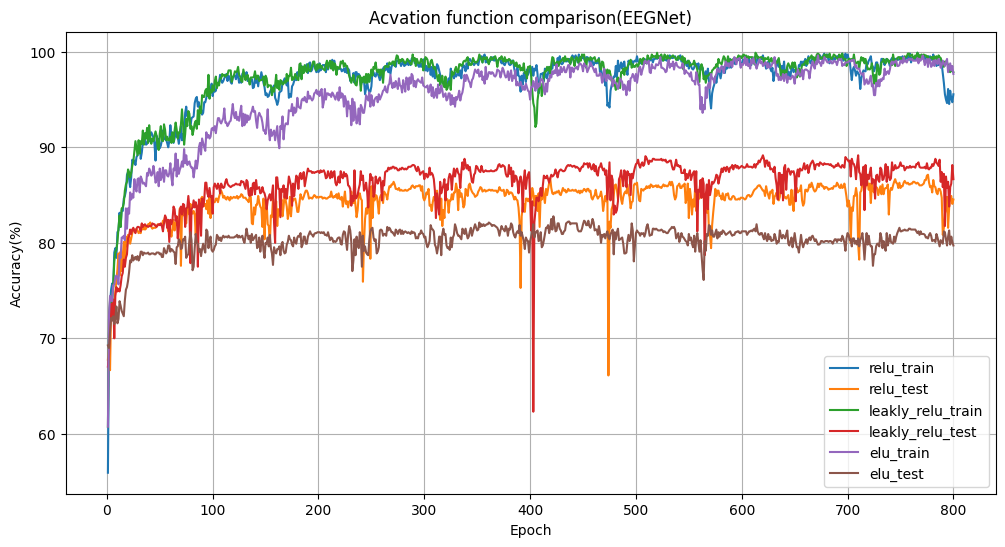

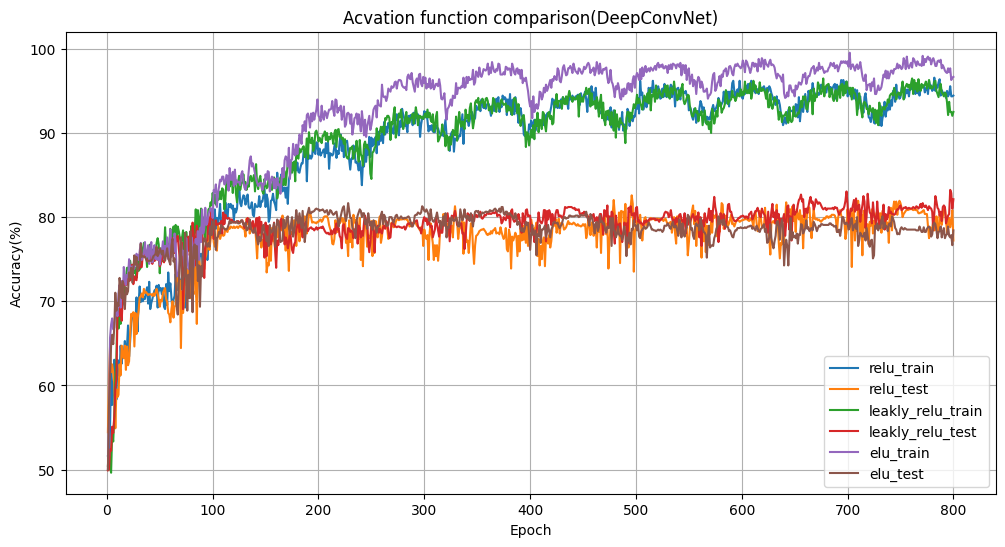

In [6]:
def plot_accuracy_trends(results, model_name='EEGNet'):
    epochs = range(1, len(results['ReLU'][model_name + '_train']) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, results['ReLU'][model_name + '_train'], label='relu_train')
    plt.plot(epochs, results['ReLU'][model_name + '_test'], label='relu_test')
    plt.plot(epochs, results['LeakyReLU'][model_name + '_train'], label='leakly_relu_train')
    plt.plot(epochs, results['LeakyReLU'][model_name + '_test'], label='leakly_relu_test')
    plt.plot(epochs, results['ELU'][model_name + '_train'], label='elu_train')
    plt.plot(epochs, results['ELU'][model_name + '_test'], label='elu_test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.title('Acvation function comparison(' + model_name + ')')
    plt.legend()
    plt.grid(True)
    plt.savefig('activation_' + model_name + '.png')
    plt.show()
    
plot_accuracy_trends(results, 'EEGNet')
plot_accuracy_trends(results, 'DeepConvNet')

In [7]:
# plot table of best accuracy for each model and activation function
import pandas as pd
def plot_table(results):
    df = pd.DataFrame(columns=['EEGNet', 'DeepConvNet'], index=['ReLU', 'LeakyReLU', 'ELU'])
    for act in activations:
        df.loc[act]['EEGNet'] = max(results[act]['EEGNet_test'])
        df.loc[act]['DeepConvNet'] = max(results[act]['DeepConvNet_test'])
    print(df.transpose())
plot_table(results)

                  ReLU  LeakyReLU        ELU
EEGNet        87.12963  89.166667  82.777778
DeepConvNet  82.592593  83.240741  81.666667


In [8]:
df = pd.DataFrame(columns=['EEGNet', 'DeepConvNet'], index=['ReLU', 'LeakyReLU', 'ELU'])
for act in activations:
    df.loc[act]['EEGNet'] = max(results[act]['EEGNet_train'])
    df.loc[act]['DeepConvNet'] = max(results[act]['DeepConvNet_train'])
print(df.transpose())

                  ReLU  LeakyReLU        ELU
EEGNet       99.907407  99.907407   99.62963
DeepConvNet  96.574074  96.481481  99.537037


In [9]:
# shallow_net = models.ShallowConvNet.ShallowConvNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(shallow_net.parameters(), lr=0.005, weight_decay=0.001) # weight_decay is L2 regularization
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
# shallow_train_accs, shallow_test_accs = train(shallow_net, train_loader, test_loader, criterion, optimizer, scheduler, epochs=800)
# shallow_results = {
#     'shallowNet_train': shallow_train_accs,
#     'shallowNet_test': shallow_test_accs,
# }

In [10]:
# epochs = range(1, len(shallow_results['shallowNet_train']) + 1)
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, shallow_results['shallowNet_train'], label='train')
# plt.plot(epochs, shallow_results['shallowNet_test'], label='test')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy(%)')
# plt.title('Acvation function comparison(ShallowConvNet)')
# plt.legend()
# plt.grid(True)
# plt.savefig('activation_ShallowConvNet.png')
# plt.show()
# print(max(shallow_results['shallowNet_train']))
# print(max(shallow_results['shallowNet_test']))